In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '{:.10f}'.format(x) if pd.notna(x) and abs(x) < 1e-9 else '{:.2f}'.format(x))


class TXFIntradayBacktest:
    '''
    這個類設計了4個method: 
    資料清理preprocessing、特徵篩選features action、回測backtest、參數最佳化與效能評估backtest logs
    '''
    def __init__(self, path: str) -> str:
        self.path = path


    def preprocessingData(self) -> pd.DataFrame:
        '''
        爬蟲下來的值可能會含千分位分隔符號、單引號、或type為str，故需轉型
        '''
        df = pd.read_csv(self.path, index_col = 'date', parse_dates = True)
        for i in range(len(df.columns)):
            if df[df.columns[i]].dtype == 'object':
                df[df.columns[i]] = df[df.columns[i]].str.replace(",", "")
                df[df.columns[i]] = df[df.columns[i]].str.replace("\'", "")
            df[df.columns[i]] = pd.to_numeric(df[df.columns[i]])   
        return df


    def Features(self, Feature) -> pd.DataFrame:
        '''
        指定交易策略(1個或N取n個) 回交有交易當日的OHLCV   若Low比Open跌超過停損點就紀錄損益為停損值   若沒停損就看①是否High減Open超過停利點 有就停利 沒有就收盤減開盤
        '''
        df = self.preprocessingData()
        df['Feature1'] = df['inst_t buy'] == df['inst_t buy'].rolling(2).max() 
        df['Feature2'] = (df['txf_close'] - df['txf_low']).rolling(4).mean() < (df['txf_high'] - df['txf_close']).rolling(4).mean() 
        df['Feature3'] = abs(df['txf_open'] - df['txf_close']).mul(2.7).rolling(5).mean() <= (df['txf_high'] - df['txf_low']).rolling(5).mean()
        df['Feature7'] = df['inst_txf_oi'] == df['inst_txf_oi'].rolling(4).max()
        df['Feature6'] = df['PutCallVol'] == df['PutCallVol'].rolling(5).min()
        df['Feature5'] = df['PutCallRatio'] == df['PutCallRatio'].rolling(9).max()
        df['Feature4'] = df['inst_f buy'] == df['inst_f buy'].rolling(7).max()
        
        if Feature != "Features":
            df['action'] = df[Feature].shift()
        else:
            df.loc[df.iloc[:,-7:].astype(int).sum(axis = 1) >= 3, 'action'] = 1
            df['action'] = df['action'].shift()
            
        dfTemp = df[df['action'] == 1].copy()[['txf_open', 'txf_high', 'txf_low', 'txf_close']]
        return dfTemp


    def BackTest(self, Feature, StopLoss, TakeProfit, _plot = False):
        '''
        將符合特徵值，預計會交易日期的OH
        '''
        dfTemp = self.Features(Feature)
        fee = 4
        dfTemp.loc[(dfTemp['txf_open'] - dfTemp['txf_low'] >  StopLoss), 'LongPnl'] = -StopLoss -fee
        dfTemp.loc[(dfTemp['txf_open'] - dfTemp['txf_low'] <= StopLoss) &  (dfTemp['txf_high'] - dfTemp['txf_open'] > TakeProfit), 'LongPnl'] = TakeProfit -fee
        dfTemp.loc[(dfTemp['txf_open'] - dfTemp['txf_low'] <= StopLoss) & ~(dfTemp['txf_high'] - dfTemp['txf_open'] > TakeProfit), 'LongPnl'] = dfTemp['txf_close'] - dfTemp['txf_open'] -fee
        
        if _plot == True:
            dfTemp['LongPnl'].cumsum().plot(figsize = (12, 5))
            plt.legend(loc = 2)

        # return dfTemp['LongPnl'].to_list()


TXFIntradayBacktest("data.csv").preprocessingData()

,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi,txf_open,txf_high,txf_low,txf_close,txf_volume,tse_open,tse_high,tse_low,tse_close,tse_volume,PutCallVol,PutCallRatio
date,,,,,,,,,,,,,,,,,,
2019-01-02,-9525531024,-47841420,-11255,35769,-4637,-3566,9760,9762,9506,9529,165919,9725.27,9737.68,9542.52,9554.14,723.31,100.13,107.87
2019-01-03,-8876753519,-676229506,-2518,33251,2598,-968,9488,9547,9433,9443,130622,9494.25,9554.53,9474.47,9492.42,898.57,81.91,98.21
2019-01-04,-9286665740,-1010008792,-3601,29651,1595,623,9367,9410,9305,9370,168543,9427.24,9427.24,9319.28,9382.51,1061.87,98.18,92.14
2019-01-07,8233740113,927803271,6510,37763,9204,3419,9541,9588,9490,9563,144887,9460.20,9596.35,9460.20,9590.30,920.57,113.88,108.83
2019-01-08,-953535515,309232983,-2188,35575,1227,4646,9600,9611,9532,9558,120551,9591.56,9600.94,9547.63,9563.60,773.13,116.39,108.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,-3223251645,3114880423,3374,1990,10523,1475,16859,17027,16836,17002,93476,16870.81,17032.32,16868.74,16996.00,3220.94,116.27,104.32
2023-08-08,-19299907898,3434941817,-2353,-367,-6498,-5007,17020,17026,16757,16853,114678,17006.46,17043.56,16812.59,16877.07,3734.59,99.66,94.54
2023-08-09,3451514813,4444478771,2264,1897,856,-4164,16815,16935,16780,16852,99083,16836.64,16956.73,16798.50,16870.94,3281.00,100.54,82.15


In [12]:
for i in ["1","2","3","4","5","6","7","s"]:
    df = TXFIntradayBacktest("data.csv").Features("Feature"+i)
    display(df.tail(3), len(df))

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-08-08,17020,17026,16757,16853
2023-08-09,16815,16935,16780,16852
2023-08-10,16788,16797,16584,16660


555

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-08-08,17020,17026,16757,16853
2023-08-09,16815,16935,16780,16852
2023-08-11,16711,16754,16574,16625


456

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-06-21,17157,17244,17140,17229
2023-06-27,16805,16855,16705,16742
2023-06-29,16851,16965,16733,16756


162

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-07-14,17219,17305,17143,17292
2023-07-26,17206,17208,17078,17102
2023-07-28,17155,17299,17135,17262


159

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-06-14,17199,17230,17133,17203
2023-07-04,17025,17116,16983,17106
2023-07-05,17086,17098,16975,17005


168

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-07-27,17183,17263,17168,17221
2023-08-04,16720,16863,16715,16824
2023-08-11,16711,16754,16574,16625


228

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-07-20,17020,17150,17018,17126
2023-07-21,16860,16984,16816,16944
2023-08-08,17020,17026,16757,16853


317

,txf_open,txf_high,txf_low,txf_close
date,,,,
2023-07-21,16860,16984,16816,16944
2023-08-04,16720,16863,16715,16824
2023-08-08,17020,17026,16757,16853


292

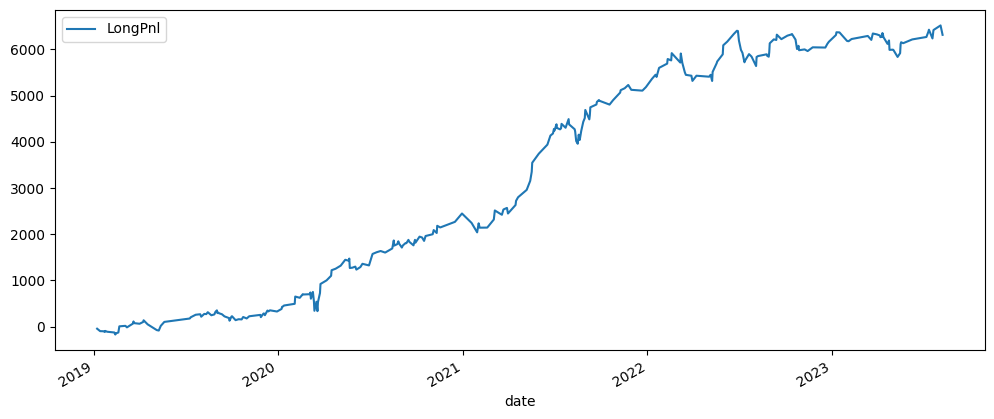

In [18]:
TXFIntradayBacktest("data.csv").BackTest("Features", 200, 200, _plot = True)

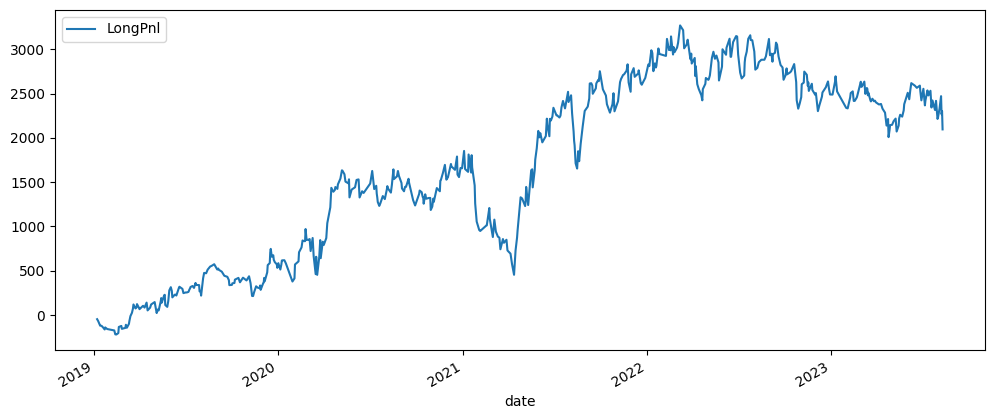

In [16]:
TXFIntradayBacktest("data.csv").BackTest("Feature1", 200, 200, _plot = True)

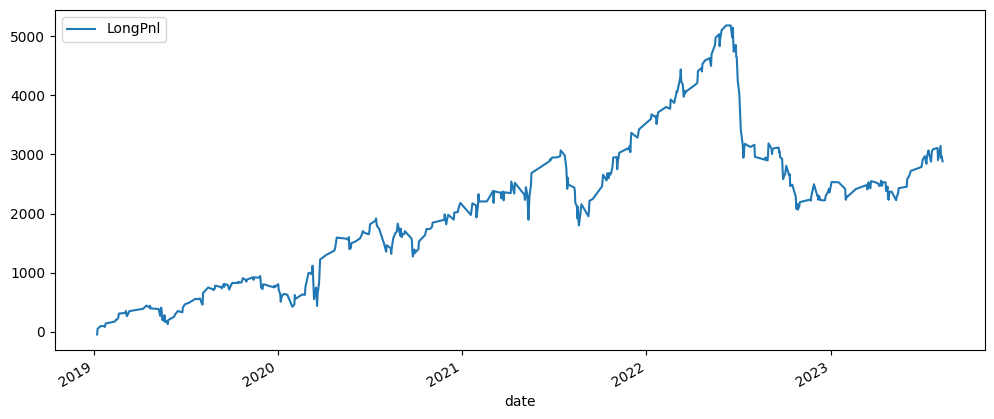

In [17]:
TXFIntradayBacktest("data.csv").BackTest("Feature2", 200, 200, _plot = True)

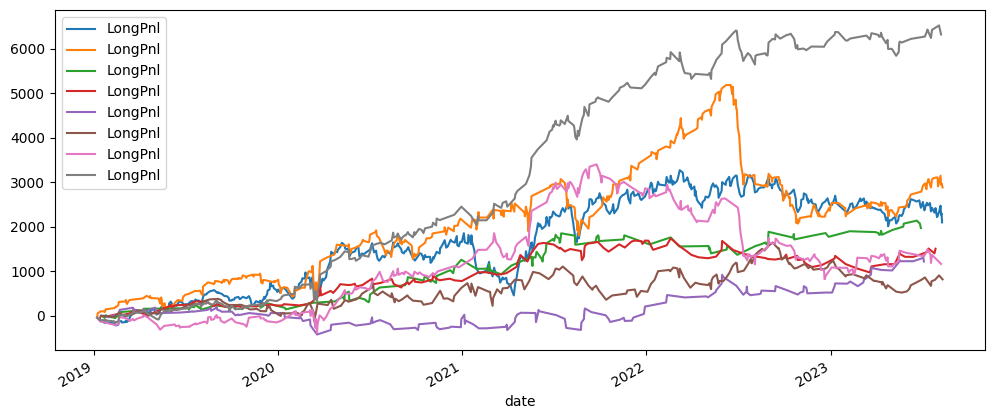

In [14]:
for i in ["1","2","3","4","5","6","7","s"]:
    TXFIntradayBacktest("data.csv").BackTest("Feature"+i, 200, 200, _plot = True)